# Synapse Tracking

In this notebook, we demonstrate the usage of the module trackpy to track synapses in two-photon microscopy images.

First, we need to set up imports.

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

from skimage import feature, filters, measure
# from skimage.external import tifffile

Here, we load in the images with which we'll be doing detection and tracking.

In [4]:
frames_z2 = pims.ImageSequence('../data/annotated_substack/substack_slices/R04_tp*_substack*01.tif')
frames_z3 = pims.ImageSequence('../data/annotated_substack/substack_slices/R04_tp*_substack*02.tif')

plos_tp1 = pims.open('../data/annotated_substack/R04_tp1_substack_results.tif')
plos_tp2 = pims.open('../data/annotated_substack/R04_tp2_substack_results.tif')
plos_tp3 = pims.open('../data/annotated_substack/R04_tp3_substack_results.tif')
plos_tp4 = pims.open('../data/annotated_substack/R04_tp4_substack_results.tif')

In [5]:
tp1_z2 = plos_tp1[1].clip(-2500, 10000)
tp1_z3 = plos_tp1[2].clip(-2500, 10000)

tp2_z2 = plos_tp2[1].clip(-2500, 10000)
tp2_z3 = plos_tp2[2].clip(-2500, 10000)

tp3_z2 = plos_tp3[1].clip(-2500, 10000)
tp3_z3 = plos_tp3[2].clip(-2500, 10000)

tp4_z2 = plos_tp4[1].clip(-2500, 10000)
tp4_z3 = plos_tp4[2].clip(-2500, 10000)

timepoints = [tp1_z2, tp1_z3, tp2_z2, tp2_z3, tp3_z2, tp3_z3, tp4_z2, tp4_z3]

## Looking at the data

Let's look at what images we're dealing with.

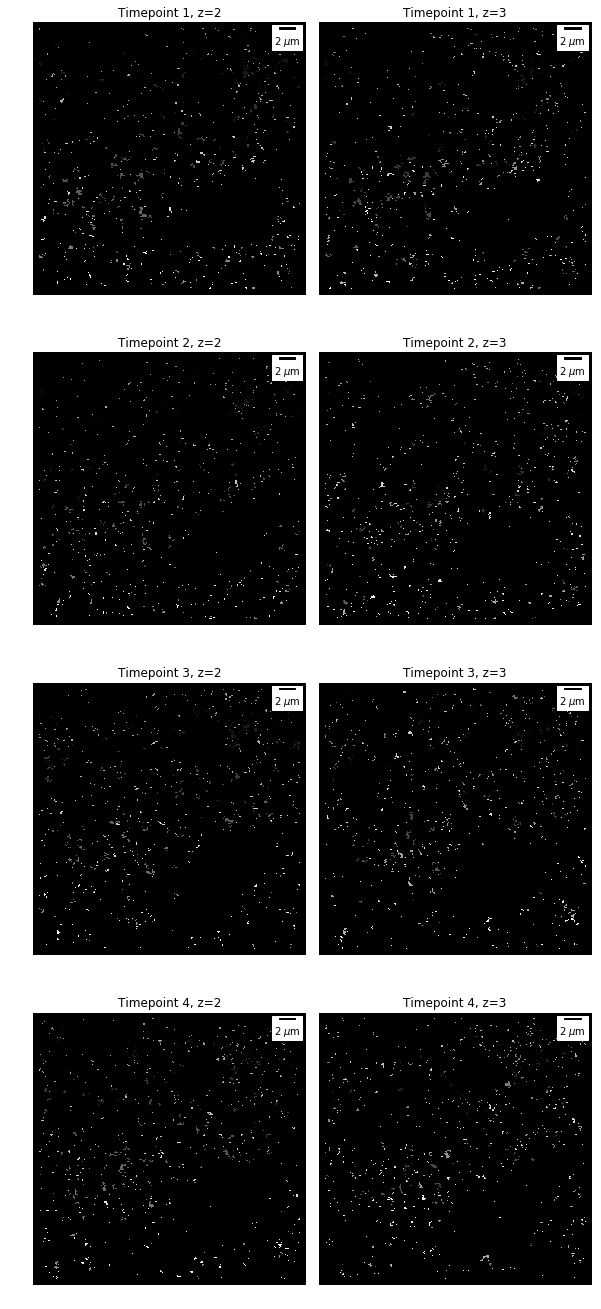

In [6]:
fig, ax = plt.subplots(4, 2, figsize=(10, 24)) 
gs1 = mpl.gridspec.GridSpec(4, 2)
gs1.update(wspace=0.05, hspace=0.05)

for i in range(8):
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.set_aspect('equal')
    ax1.imshow(timepoints[i])
    title = 'Timepoint {}, z={}'.format(int(np.ceil((i+1)/2)), i%2 + 2)
    ax1.set_title(title)
    scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
    ax1.add_artist(scalebar)

## Looking at the annotations

Now, let's import the annotations and see where they fall on the images.

In [7]:
tp1_annotations_a = pd.read_csv('../data/annotated_substack/R04_tp1_substack_Austin.csv')
tp1_annotations_r = pd.read_csv('../data/annotated_substack/R04_tp1_substack_RR.csv')

tp2_annotations_a = pd.read_csv('../data/annotated_substack/R04_tp2_substack_Austin.csv')
tp2_annotations_r = pd.read_csv('../data/annotated_substack/R04_tp2_substack_RR.csv')

tp3_annotations_a = pd.read_csv('../data/annotated_substack/R04_tp3_substack_Austin.csv')
tp3_annotations_r = pd.read_csv('../data/annotated_substack/R04_tp3_substack_RR.csv')

tp4_annotations_a = pd.read_csv('../data/annotated_substack/R04_tp4_substack_Austin.csv')
tp4_annotations_r = pd.read_csv('../data/annotated_substack/R04_tp4_substack_RR.csv')

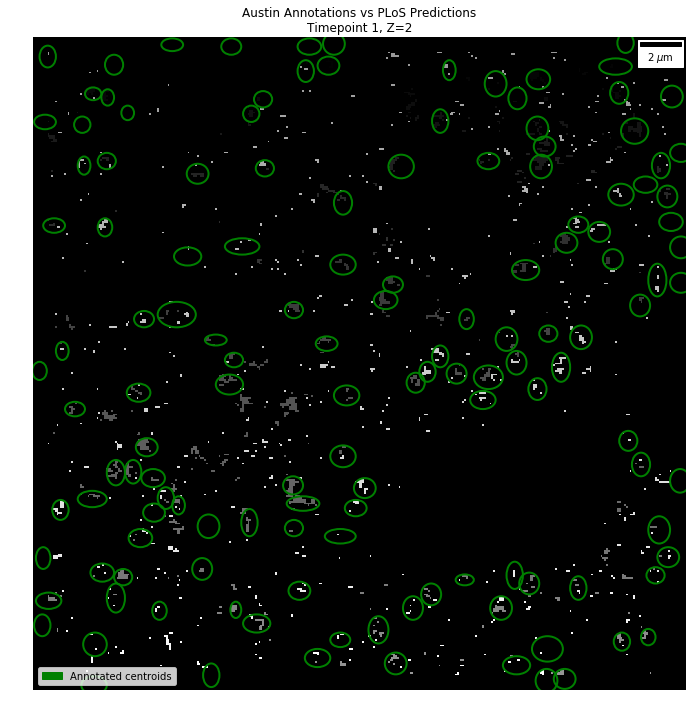

In [8]:
plt.figure(figsize=(12,12))
plt.gca().imshow(timepoints[0])
for idx, row in tp1_annotations_a[tp1_annotations_a['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    plt.gca().add_patch(elps)

annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
plt.legend(handles=[annotation_patch])
plt.axis('off')
plt.title('Austin Annotations vs PLoS Predictions\nTimepoint 1, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar)

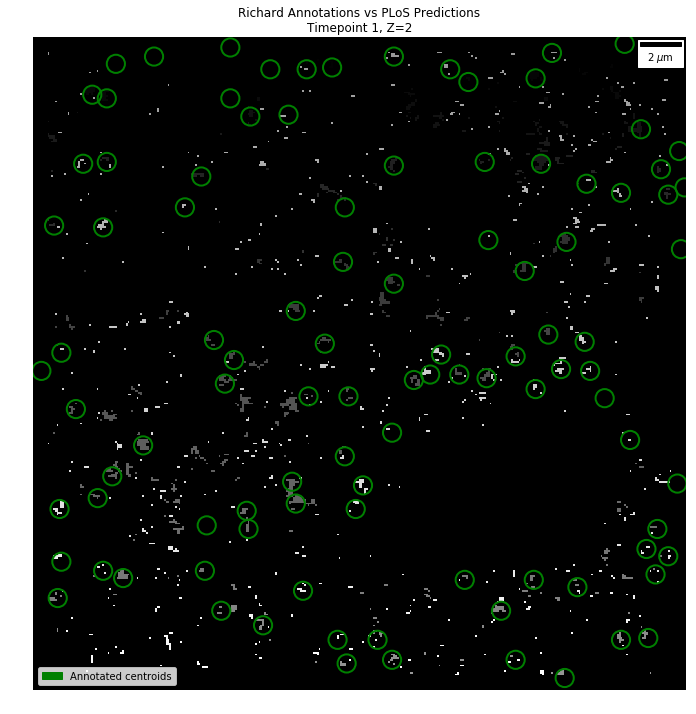

In [9]:
plt.figure(figsize=(12,12))
plt.gca().imshow(timepoints[0])
for idx, row in tp1_annotations_r[tp1_annotations_r['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    plt.gca().add_patch(elps)

annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
plt.legend(handles=[annotation_patch])
plt.axis('off')
plt.title('Richard Annotations vs PLoS Predictions\nTimepoint 1, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar)

## Distribution of mass/area of predicted synapses

Now, let's look at the frequencies of mass and intensity in the images. For simplicity, we'll only look at the first timepoint. For this, we use region detection algorithms on the PLoS predictions. This effectively lets us extract regions of interest (synapses) from the prediction image.

First, we need to label the image of results. Then, we can extract regions from the labeled image.

In [10]:
label_im = measure.label(np.array(timepoints[0]))
mass = []
area_px = []
area_um = []

for region in measure.regionprops(label_im, timepoints[0]):
    area_px.append(region.area)
    area_um.append(region.area * 0.09 * 0.09)
    mass.append(region.weighted_moments[0][0])


Alright, let's see first where the detected synapses are.

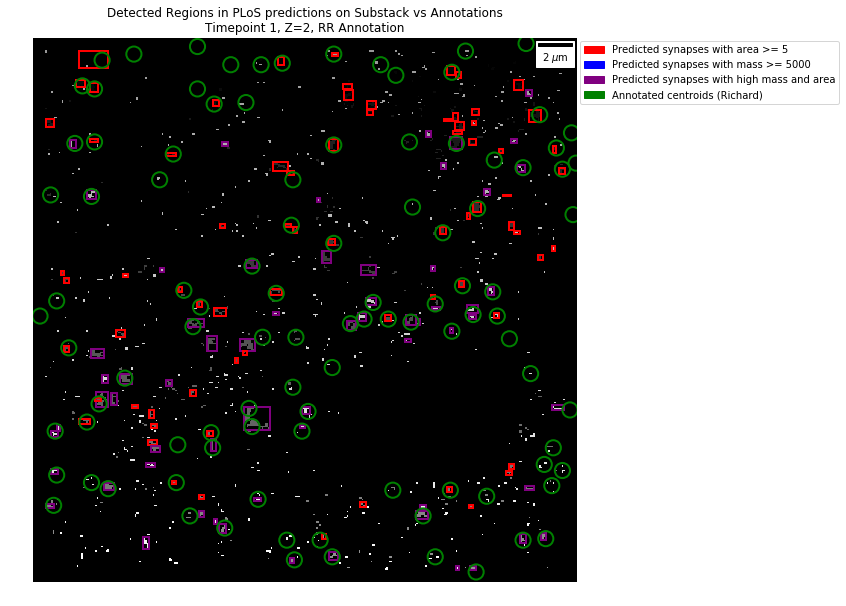

In [119]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Detected Regions in PLoS predictions on Substack vs Annotations\nTimepoint 1, Z=2, RR Annotation')
ax.imshow(timepoints[0])

purple_centers_r = []
red_centers_r = []
blue_centers_r = []

for region in measure.regionprops(label_im, timepoints[0]):
    if region.area >= 5 and region.weighted_moments[0][0] >= 5000:
        # draw rectangle around segmented points
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='purple', linewidth=2)
        ax.add_patch(rect)
        purple_centers_r.append(region.centroid)

    elif region.weighted_moments[0][0] >= 5000:
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(rect)
        blue_centers_r.append(region.centroid)


    elif region.area >= 5:
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        red_centers_r.append(region.centroid)
            
for idx, row in tp1_annotations_r[tp1_annotations_r['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    ax.add_patch(elps)  

red_patch = mpl.patches.Patch(color='red', label='Predicted synapses with area >= 5')
blue_patch = mpl.patches.Patch(color='blue', label='Predicted synapses with mass >= 5000')    
purple_patch = mpl.patches.Patch(color='purple', label='Predicted synapses with high mass and area')
annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids (Richard)')

plt.legend(handles=[red_patch, blue_patch, purple_patch, annotation_patch], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.3)
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
ax.add_artist(scalebar)
ax.axis('off');

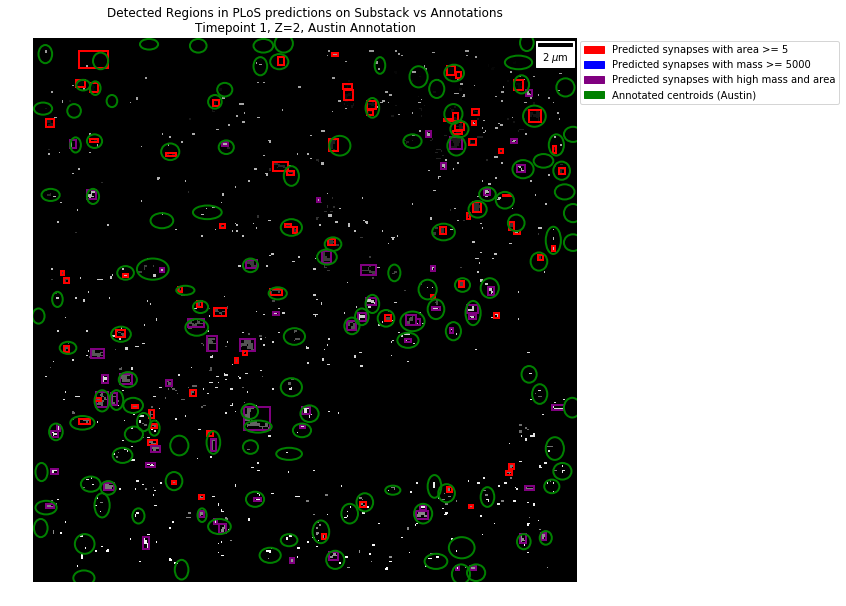

In [210]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Detected Regions in PLoS predictions on Substack vs Annotations\nTimepoint 1, Z=2, Austin Annotation')
ax.imshow(timepoints[0])

purple_centers_a = []
red_centers_a = []
blue_centers_a = []

for region in measure.regionprops(label_im, timepoints[0]):
    if region.area >= 5 and region.weighted_moments[0][0] >= 5000:
        # draw rectangle around segmented points
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='purple', linewidth=2)
        ax.add_patch(rect)
        purple_centers_a.append(region.centroid)

    elif region.weighted_moments[0][0] >= 5000:
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(rect)
        blue_centers_a.append(region.centroid)


    elif region.area >= 5:
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        red_centers_a.append(region.centroid)
            
for idx, row in tp1_annotations_a[tp1_annotations_a['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    ax.add_patch(elps)  

red_patch = mpl.patches.Patch(color='red', label='Predicted synapses with area >= 5')
blue_patch = mpl.patches.Patch(color='blue', label='Predicted synapses with mass >= 5000')    
purple_patch = mpl.patches.Patch(color='purple', label='Predicted synapses with high mass and area')
annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids (Austin)')

plt.legend(handles=[red_patch, blue_patch, purple_patch, annotation_patch], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.3)
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
ax.add_artist(scalebar)
ax.axis('off');
plt.savefig('../figures/annotations_substack.PNG', dpi=300)

## Measuring F-1

To quantify how good the PLoS predictions are, we measure the F-1 score relative to both sets of expert annotations (Austin and Richard).

First up, we'll calculate F-1 relative to Austin's predictions. A predicted synapse is considered "correct" if the center of predicted synapse lies within the bounding box of the annotation ellipse. 


In [238]:
def overlap(predicted_regions, annotations):
    annotation_per_pred = dict()
    for region in predicted_regions:
        annotation_per_pred[region.centroid] = []
        for idx, row in annotations.iterrows():
            xmin = row['X']
            xmax = row['X'] + row['Width']
            ymin = row['Y']
            ymax = row['Y'] + row['Height']
            if region.centroid[1] <= xmax and region.centroid[1] >= xmin \
                and region.centroid[0] <= ymax and region.centroid[0] >= ymin:
                annotation_per_pred[region.centroid].append((row['X'], row['Y']))

    pred_per_annotation = dict()
    for idx, row in annotations.iterrows():
        pred_per_annotation[(row['X'], row['Y'])] = []
        for region in predicted_regions:
            xmin = row['X']
            xmax = row['X'] + row['Width']
            ymin = row['Y']
            ymax = row['Y'] + row['Height']
            if region.centroid[1] <= xmax and region.centroid[1] >= xmin \
                and region.centroid[0] <= ymax and region.centroid[0] >= ymin:
                pred_per_annotation[(row['X'], row['Y'])].append(region.centroid)

    return {'pred_per_ann': pred_per_annotation, 'ann_per_pred': annotation_per_pred}

In [239]:
def compute_stats(overlap_dict):
    arr = np.array([len(overlap_dict['ann_per_pred'][key]) for key in overlap_dict['ann_per_pred'].keys()])
    tp = np.sum([arr >= 1])
    fp = np.sum([arr == 0])

    arr = np.array([len(overlap_dict['pred_per_ann'][key]) for key in overlap_dict['pred_per_ann'].keys()])
    tn = np.sum([arr >= 1])
    fn = np.sum([arr == 0])
    
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = (2 * prec * rec) / (prec + rec)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return prec, rec, f1, sensitivity, specificity

In [240]:
def f1_plot(input_img, annotations, out_img):
    label_img = measure.label(np.array(input_img))

    #Finding max mass, area for thresholding
    mass = area = 0
    for region in measure.regionprops(label_img, input_img):
        mass = max(mass, region.weighted_moments[0][0])
        area = max(area, region.area)
        
    area_stats = []
    mass_stats = []
        
    for area_threshold in np.linspace(0, 40, num=40):
        region_thresh = []
        for region in measure.regionprops(label_img, input_img):
            if region.area >= area_threshold:
                region_thresh.append(region)
        
        overlap_dict = overlap(region_thresh, annotations)
        area_stats.append(compute_stats(overlap_dict))
        
    area_stats = np.array(area_stats)
    
    for mass_threshold in np.linspace(0, mass/3, num=40):
        region_thresh = []
        for region in measure.regionprops(label_img, input_img):
            if region.weighted_moments[0][0] >= mass_threshold:
                region_thresh.append(region)
        
        overlap_dict = overlap(region_thresh, annotations)
        mass_stats.append(compute_stats(overlap_dict))

    mass_stats = np.array(mass_stats)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title('Precision/Recall Curves with Area Thresholding')
    ax1.set_xlabel('Area Threshold')
    ax1.plot(np.linspace(0, 40, num=40), area_stats[:,0], label='Precision')
    ax1.plot(np.linspace(0, 40, num=40), area_stats[:,1], label='Recall')
    ax1.plot(np.linspace(0, 40, num=40), area_stats[:,2], label='F-l score')
    ax1.legend()
    
    ax2.set_title('Precision/Recall Curves with Mass Thresholding')
    ax2.set_xlabel('Mass Threshold')
    ax2.plot(np.linspace(0, mass, num=40), mass_stats[:,0], label='Precision')
    ax2.plot(np.linspace(0, mass, num=40), mass_stats[:,1], label='Recall')
    ax2.plot(np.linspace(0, mass, num=40), mass_stats[:,2], label='F-l score')
    ax2.legend()
    plt.savefig(out_img, dpi=300)
    
        
    area_max_f1 = np.argmax(area_stats[:,2])
    mass_max_f1 = np.argmax(mass_stats[:,2])
    
    return (area_stats[area_max_f1, 0:3], mass_stats[mass_max_f1])
    

In [230]:
a = np.arange(6).reshape((3, 2))
print(a, a[0:3,1])

[[0 1]
 [2 3]
 [4 5]] [1 3 5]


TypeError: list indices must be integers or slices, not tuple

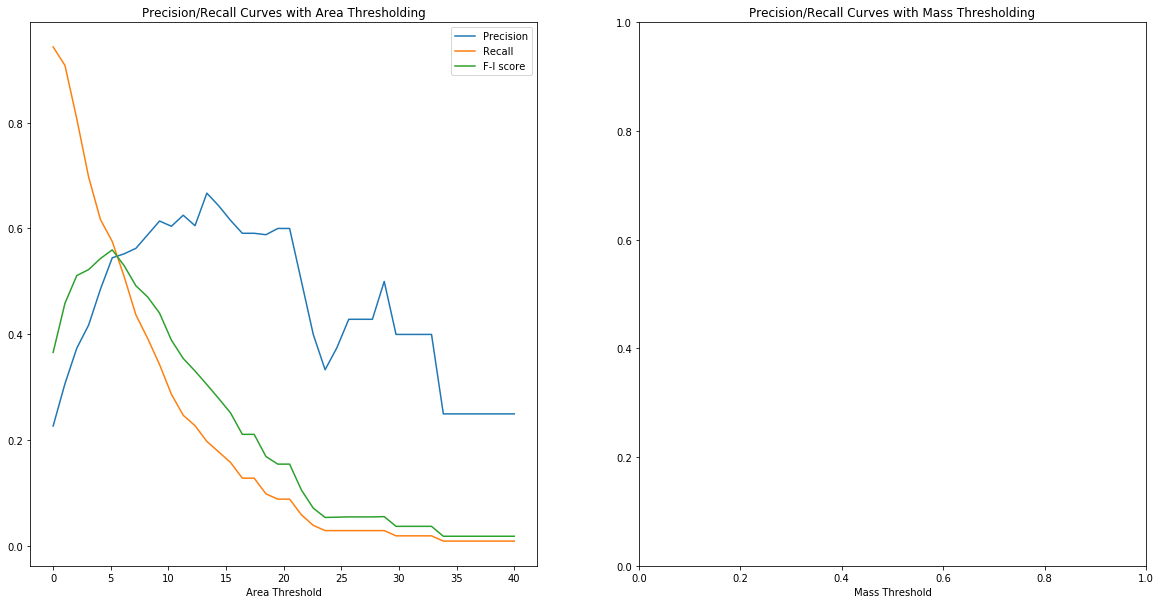

In [232]:
results = f1_plot(timepoints[0], tp1_annotations_r[tp1_annotations_r['Z']==2], '../figures/prec_recall_area_mass_thresholding_austin.PNG')

In [ ]:
print(results)

In [ ]:
results_a = f1_plot(timepoints[0], tp1_annotations_a[tp1_annotations_a['Z']==2], '../figures/prec_recall_area_mass_thresholding_austin.PNG')

In [ ]:
print(results_a)

In [241]:
def stats_multithreshold(input_img, annotations):
    label_img = measure.label(np.array(input_img))

    #Finding max mass, area for thresholding
    mass = area = 0
    for region in measure.regionprops(label_img, input_img):
        mass = max(mass, region.weighted_moments[0][0])
        area = max(area, region.area)

    stats = []
        
    for area_threshold in np.linspace(0, 40, num=40):
        for mass_threshold in np.linspace(0, mass/3, num=40):
            print('Area = {}\nMass = {}'.format(area_threshold, mass_threshold))
            region_thresh = []
            for region in measure.regionprops(label_img, input_img):
                if region.weighted_moments[0][0] >= mass_threshold \
                    and region.area >= area_threshold:
                    region_thresh.append(region)

            overlap_dict = overlap(region_thresh, annotations)
            stats.append(compute_stats(overlap_dict))
            
    return stats

In [242]:
stats = stats_multithreshold(timepoints[0], tp1_annotations_a[tp1_annotations_a['Z']==2])

Area = 0.0
Mass = 0.0
Area = 0.0
Mass = 299.0769230769231
Area = 0.0
Mass = 598.1538461538462
Area = 0.0
Mass = 897.2307692307693
Area = 0.0
Mass = 1196.3076923076924
Area = 0.0
Mass = 1495.3846153846155
Area = 0.0
Mass = 1794.4615384615386
Area = 0.0
Mass = 2093.538461538462
Area = 0.0
Mass = 2392.6153846153848
Area = 0.0
Mass = 2691.6923076923076
Area = 0.0
Mass = 2990.769230769231
Area = 0.0
Mass = 3289.8461538461543
Area = 0.0
Mass = 3588.923076923077
Area = 0.0
Mass = 3888.0
Area = 0.0
Mass = 4187.076923076924
Area = 0.0
Mass = 4486.153846153847
Area = 0.0
Mass = 4785.2307692307695
Area = 0.0
Mass = 5084.307692307692
Area = 0.0
Mass = 5383.384615384615
Area = 0.0
Mass = 5682.461538461539
Area = 0.0
Mass = 5981.538461538462
Area = 0.0
Mass = 6280.615384615385
Area = 0.0
Mass = 6579.6923076923085
Area = 0.0
Mass = 6878.769230769231
Area = 0.0
Mass = 7177.846153846154
Area = 0.0
Mass = 7476.923076923077
Area = 0.0
Mass = 7776.0
Area = 0.0
Mass = 8075.076923076924
Area = 0.0
Mass = 83

Area = 4.102564102564102
Mass = 5084.307692307692
Area = 4.102564102564102
Mass = 5383.384615384615
Area = 4.102564102564102
Mass = 5682.461538461539
Area = 4.102564102564102
Mass = 5981.538461538462
Area = 4.102564102564102
Mass = 6280.615384615385
Area = 4.102564102564102
Mass = 6579.6923076923085
Area = 4.102564102564102
Mass = 6878.769230769231
Area = 4.102564102564102
Mass = 7177.846153846154
Area = 4.102564102564102
Mass = 7476.923076923077
Area = 4.102564102564102
Mass = 7776.0
Area = 4.102564102564102
Mass = 8075.076923076924
Area = 4.102564102564102
Mass = 8374.153846153848
Area = 4.102564102564102
Mass = 8673.23076923077
Area = 4.102564102564102
Mass = 8972.307692307693
Area = 4.102564102564102
Mass = 9271.384615384615
Area = 4.102564102564102
Mass = 9570.461538461539
Area = 4.102564102564102
Mass = 9869.538461538463
Area = 4.102564102564102
Mass = 10168.615384615385
Area = 4.102564102564102
Mass = 10467.692307692309
Area = 4.102564102564102
Mass = 10766.76923076923
Area = 4.

Area = 8.205128205128204
Mass = 7177.846153846154
Area = 8.205128205128204
Mass = 7476.923076923077
Area = 8.205128205128204
Mass = 7776.0
Area = 8.205128205128204
Mass = 8075.076923076924
Area = 8.205128205128204
Mass = 8374.153846153848
Area = 8.205128205128204
Mass = 8673.23076923077
Area = 8.205128205128204
Mass = 8972.307692307693
Area = 8.205128205128204
Mass = 9271.384615384615
Area = 8.205128205128204
Mass = 9570.461538461539
Area = 8.205128205128204
Mass = 9869.538461538463
Area = 8.205128205128204
Mass = 10168.615384615385
Area = 8.205128205128204
Mass = 10467.692307692309
Area = 8.205128205128204
Mass = 10766.76923076923
Area = 8.205128205128204
Mass = 11065.846153846154
Area = 8.205128205128204
Mass = 11364.923076923078
Area = 8.205128205128204
Mass = 11664.0
Area = 9.23076923076923
Mass = 0.0
Area = 9.23076923076923
Mass = 299.0769230769231
Area = 9.23076923076923
Mass = 598.1538461538462
Area = 9.23076923076923
Mass = 897.2307692307693
Area = 9.23076923076923
Mass = 1196.

Area = 12.307692307692307
Mass = 8972.307692307693
Area = 12.307692307692307
Mass = 9271.384615384615
Area = 12.307692307692307
Mass = 9570.461538461539
Area = 12.307692307692307
Mass = 9869.538461538463
Area = 12.307692307692307
Mass = 10168.615384615385
Area = 12.307692307692307
Mass = 10467.692307692309
Area = 12.307692307692307
Mass = 10766.76923076923
Area = 12.307692307692307
Mass = 11065.846153846154
Area = 12.307692307692307
Mass = 11364.923076923078
Area = 12.307692307692307
Mass = 11664.0
Area = 13.333333333333332
Mass = 0.0
Area = 13.333333333333332
Mass = 299.0769230769231
Area = 13.333333333333332
Mass = 598.1538461538462
Area = 13.333333333333332
Mass = 897.2307692307693
Area = 13.333333333333332
Mass = 1196.3076923076924
Area = 13.333333333333332
Mass = 1495.3846153846155
Area = 13.333333333333332
Mass = 1794.4615384615386
Area = 13.333333333333332
Mass = 2093.538461538462
Area = 13.333333333333332
Mass = 2392.6153846153848
Area = 13.333333333333332
Mass = 2691.692307692

Area = 16.41025641025641
Mass = 10467.692307692309
Area = 16.41025641025641
Mass = 10766.76923076923
Area = 16.41025641025641
Mass = 11065.846153846154
Area = 16.41025641025641
Mass = 11364.923076923078
Area = 16.41025641025641
Mass = 11664.0
Area = 17.435897435897434
Mass = 0.0
Area = 17.435897435897434
Mass = 299.0769230769231
Area = 17.435897435897434
Mass = 598.1538461538462
Area = 17.435897435897434
Mass = 897.2307692307693
Area = 17.435897435897434
Mass = 1196.3076923076924
Area = 17.435897435897434
Mass = 1495.3846153846155
Area = 17.435897435897434
Mass = 1794.4615384615386
Area = 17.435897435897434
Mass = 2093.538461538462
Area = 17.435897435897434
Mass = 2392.6153846153848
Area = 17.435897435897434
Mass = 2691.6923076923076
Area = 17.435897435897434
Mass = 2990.769230769231
Area = 17.435897435897434
Mass = 3289.8461538461543
Area = 17.435897435897434
Mass = 3588.923076923077
Area = 17.435897435897434
Mass = 3888.0
Area = 17.435897435897434
Mass = 4187.076923076924
Area = 17.4

Area = 21.538461538461537
Mass = 299.0769230769231
Area = 21.538461538461537
Mass = 598.1538461538462
Area = 21.538461538461537
Mass = 897.2307692307693
Area = 21.538461538461537
Mass = 1196.3076923076924
Area = 21.538461538461537
Mass = 1495.3846153846155
Area = 21.538461538461537
Mass = 1794.4615384615386
Area = 21.538461538461537
Mass = 2093.538461538462
Area = 21.538461538461537
Mass = 2392.6153846153848
Area = 21.538461538461537
Mass = 2691.6923076923076
Area = 21.538461538461537
Mass = 2990.769230769231
Area = 21.538461538461537
Mass = 3289.8461538461543
Area = 21.538461538461537
Mass = 3588.923076923077
Area = 21.538461538461537
Mass = 3888.0
Area = 21.538461538461537
Mass = 4187.076923076924
Area = 21.538461538461537
Mass = 4486.153846153847
Area = 21.538461538461537
Mass = 4785.2307692307695
Area = 21.538461538461537
Mass = 5084.307692307692
Area = 21.538461538461537
Mass = 5383.384615384615
Area = 21.538461538461537
Mass = 5682.461538461539
Area = 21.538461538461537
Mass = 59

Area = 25.64102564102564
Mass = 1495.3846153846155
Area = 25.64102564102564
Mass = 1794.4615384615386
Area = 25.64102564102564
Mass = 2093.538461538462
Area = 25.64102564102564
Mass = 2392.6153846153848
Area = 25.64102564102564
Mass = 2691.6923076923076
Area = 25.64102564102564
Mass = 2990.769230769231
Area = 25.64102564102564
Mass = 3289.8461538461543
Area = 25.64102564102564
Mass = 3588.923076923077
Area = 25.64102564102564
Mass = 3888.0
Area = 25.64102564102564
Mass = 4187.076923076924
Area = 25.64102564102564
Mass = 4486.153846153847
Area = 25.64102564102564
Mass = 4785.2307692307695
Area = 25.64102564102564
Mass = 5084.307692307692
Area = 25.64102564102564
Mass = 5383.384615384615
Area = 25.64102564102564
Mass = 5682.461538461539
Area = 25.64102564102564
Mass = 5981.538461538462
Area = 25.64102564102564
Mass = 6280.615384615385
Area = 25.64102564102564
Mass = 6579.6923076923085
Area = 25.64102564102564
Mass = 6878.769230769231
Area = 25.64102564102564
Mass = 7177.846153846154
Area

Area = 29.74358974358974
Mass = 2990.769230769231
Area = 29.74358974358974
Mass = 3289.8461538461543
Area = 29.74358974358974
Mass = 3588.923076923077
Area = 29.74358974358974
Mass = 3888.0
Area = 29.74358974358974
Mass = 4187.076923076924
Area = 29.74358974358974
Mass = 4486.153846153847
Area = 29.74358974358974
Mass = 4785.2307692307695
Area = 29.74358974358974
Mass = 5084.307692307692
Area = 29.74358974358974
Mass = 5383.384615384615
Area = 29.74358974358974
Mass = 5682.461538461539
Area = 29.74358974358974
Mass = 5981.538461538462
Area = 29.74358974358974
Mass = 6280.615384615385
Area = 29.74358974358974
Mass = 6579.6923076923085
Area = 29.74358974358974
Mass = 6878.769230769231
Area = 29.74358974358974
Mass = 7177.846153846154
Area = 29.74358974358974
Mass = 7476.923076923077
Area = 29.74358974358974
Mass = 7776.0
Area = 29.74358974358974
Mass = 8075.076923076924
Area = 29.74358974358974
Mass = 8374.153846153848
Area = 29.74358974358974
Mass = 8673.23076923077
Area = 29.7435897435

Area = 33.84615384615384
Mass = 4785.2307692307695
Area = 33.84615384615384
Mass = 5084.307692307692
Area = 33.84615384615384
Mass = 5383.384615384615
Area = 33.84615384615384
Mass = 5682.461538461539
Area = 33.84615384615384
Mass = 5981.538461538462
Area = 33.84615384615384
Mass = 6280.615384615385
Area = 33.84615384615384
Mass = 6579.6923076923085
Area = 33.84615384615384
Mass = 6878.769230769231
Area = 33.84615384615384
Mass = 7177.846153846154
Area = 33.84615384615384
Mass = 7476.923076923077
Area = 33.84615384615384
Mass = 7776.0
Area = 33.84615384615384
Mass = 8075.076923076924
Area = 33.84615384615384
Mass = 8374.153846153848
Area = 33.84615384615384
Mass = 8673.23076923077
Area = 33.84615384615384
Mass = 8972.307692307693
Area = 33.84615384615384
Mass = 9271.384615384615
Area = 33.84615384615384
Mass = 9570.461538461539
Area = 33.84615384615384
Mass = 9869.538461538463
Area = 33.84615384615384
Mass = 10168.615384615385
Area = 33.84615384615384
Mass = 10467.692307692309
Area = 3

Area = 37.94871794871794
Mass = 7476.923076923077
Area = 37.94871794871794
Mass = 7776.0
Area = 37.94871794871794
Mass = 8075.076923076924
Area = 37.94871794871794
Mass = 8374.153846153848
Area = 37.94871794871794
Mass = 8673.23076923077
Area = 37.94871794871794
Mass = 8972.307692307693
Area = 37.94871794871794
Mass = 9271.384615384615
Area = 37.94871794871794
Mass = 9570.461538461539
Area = 37.94871794871794
Mass = 9869.538461538463
Area = 37.94871794871794
Mass = 10168.615384615385
Area = 37.94871794871794
Mass = 10467.692307692309
Area = 37.94871794871794
Mass = 10766.76923076923
Area = 37.94871794871794
Mass = 11065.846153846154
Area = 37.94871794871794
Mass = 11364.923076923078
Area = 37.94871794871794
Mass = 11664.0
Area = 38.97435897435897
Mass = 0.0
Area = 38.97435897435897
Mass = 299.0769230769231
Area = 38.97435897435897
Mass = 598.1538461538462
Area = 38.97435897435897
Mass = 897.2307692307693
Area = 38.97435897435897
Mass = 1196.3076923076924
Area = 38.97435897435897
Mass =

In [254]:
stats = np.array(stats).reshape(40, 40, -1)

In [347]:
print(np.unravel_index(stats[:,:,2].argmax(), stats[:,:,2].shape))

(3, 0)


In [348]:
print(stats[3,0,:])

[0.63736264 0.725      0.67836257 0.725      0.5875    ]


In [332]:
prec = pd.DataFrame(stats[:,:,0], columns=np.arange(0, 11660, 291.5), index=np.linspace(0, 39, num=40))
recall = pd.DataFrame(stats[:,:,1], columns=np.arange(0, 11660, 291.5), index=np.linspace(0, 39, num=40))
f1 = pd.DataFrame(stats[:,:,2], columns=np.arange(0, 11660, 291.5), index=np.linspace(0, 39, num=40))

In [356]:
f1

,0.0,291.5,583.0,874.5,1166.0,1457.5,1749.0,2040.5,2332.0,2623.5,...,8745.0,9036.5,9328.0,9619.5,9911.0,10202.5,10494.0,10785.5,11077.0,11368.5
0.0,0.523161,0.520309,0.520462,0.541147,0.563830,0.556237,0.557078,0.546419,0.578462,0.570470,...,0.173913,0.162500,0.163522,0.153846,0.129870,0.130719,0.118421,0.105960,0.107383,0.108108
1.0,0.596491,0.589786,0.594783,0.586957,0.569260,0.556237,0.557078,0.546419,0.578462,0.570470,...,0.173913,0.162500,0.163522,0.153846,0.129870,0.130719,0.118421,0.105960,0.107383,0.108108
2.0,0.650718,0.640394,0.642857,0.627660,0.607735,0.595989,0.582583,0.566038,0.567742,0.570470,...,0.173913,0.162500,0.163522,0.153846,0.129870,0.130719,0.118421,0.105960,0.107383,0.108108
3.0,0.678363,0.670659,0.668712,0.647436,0.631579,0.619529,0.605634,0.589928,0.586957,0.573529,...,0.173913,0.162500,0.163522,0.153846,0.129870,0.130719,0.118421,0.105960,0.107383,0.108108
4.0,0.648084,0.636042,0.630824,0.609665,0.593156,0.590038,0.576000,0.558704,0.560976,0.551440,...,0.173913,0.162500,0.163522,0.153846,0.129870,0.130719,0.118421,0.105960,0.107383,0.108108
5.0,0.607692,0.596899,0.593750,0.566802,0.547718,0.543933,0.528139,0.508772,0.508772,0.504425,...,0.173913,0.162500,0.163522,0.153846,0.129870,0.130719,0.118421,0.105960,0.107383,0.108108
6.0,0.578512,0.566667,0.563025,0.532751,0.517857,0.511211,0.497696,0.490741,0.490741,0.483721,...,0.173913,0.162500,0.163522,0.153846,0.129870,0.130719,0.118421,0.105960,0.107383,0.108108
7.0,0.529148,0.515837,0.511416,0.483412,0.478469,0.478469,0.468293,0.460784,0.460784,0.453202,...,0.173913,0.162500,0.163522,0.153846,0.129870,0.130719,0.118421,0.105960,0.107383,0.108108
8.0,0.483092,0.468293,0.460784,0.432161,0.426396,0.426396,0.422680,0.414508,0.414508,0.406250,...,0.173913,0.162500,0.163522,0.153846,0.129870,0.130719,0.118421,0.105960,0.107383,0.108108
9.0,0.438776,0.430769,0.422680,0.391534,0.382979,0.382979,0.378378,0.369565,0.369565,0.360656,...,0.164557,0.152866,0.152866,0.141935,0.129870,0.130719,0.118421,0.105960,0.107383,0.108108


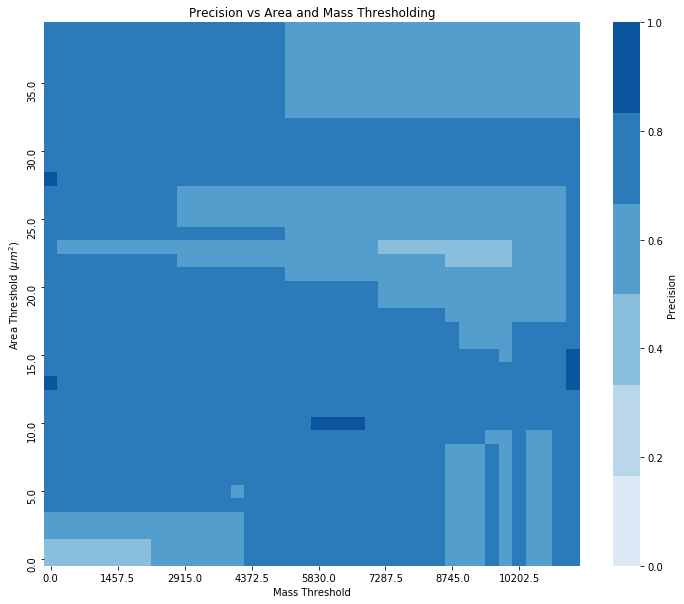

In [364]:
import seaborn as sns

plt.figure(figsize=(12, 10))
ax = sns.heatmap(prec, cmap=sns.color_palette("Blues"), xticklabels=5, yticklabels=5, cbar_kws={'label': 'Precision'}, vmin=0, vmax=1)
ax.set(title='Precision vs Area and Mass Thresholding', xlabel='Mass Threshold', ylabel=r'Area Threshold ($\mu m^2$)')
ax.set(ylim=(0, 40))
plt.show()
fig = ax.get_figure()
fig.savefig('../figures/precision_heatmap.PNG', dpi=300)

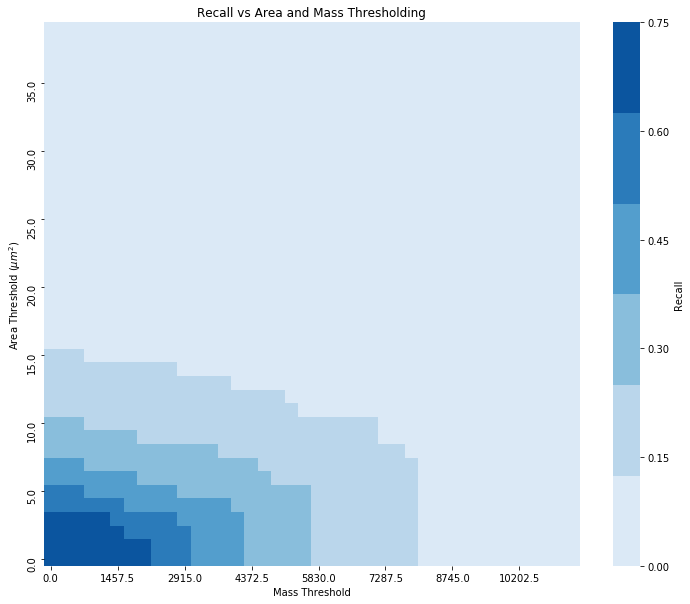

In [365]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(recall, cmap=sns.color_palette("Blues"), xticklabels=5, yticklabels=5, cbar_kws={'label': 'Recall'}, vmax=0, vmin=0.75)
ax.set(title='Recall vs Area and Mass Thresholding', xlabel='Mass Threshold', ylabel=r'Area Threshold ($\mu m^2$)')
ax.set(ylim=(0, 40))
plt.show()
fig = ax.get_figure()
fig.savefig('../figures/recall_heatmap.PNG', dpi=300)

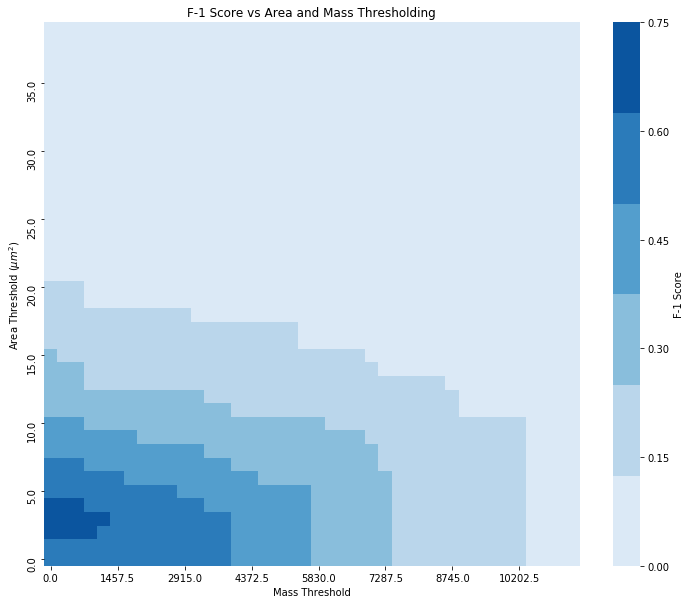

In [366]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(f1, cmap=sns.color_palette("Blues"), xticklabels=5, yticklabels=5, cbar_kws={'label': 'F-1 Score'}, vmin=0, vmax=.75)
ax.set(title='F-1 Score vs Area and Mass Thresholding', xlabel='Mass Threshold', ylabel=r'Area Threshold ($\mu m^2$)')
ax.set(ylim=(0, 40))
plt.show()
fig = ax.get_figure()
fig.savefig('../figures/f1_heatmap.PNG', dpi=300)

As you can see, the precision and recall for Austin's annotations and Richard's annotations are very similar.

## Tracking!

First, we'll demonstrate tracking using PLoS synapses and the PLoS results image.

In [142]:
f = tp.locate(frames_z2[1], 5) #Arguments are image and expected size of object, in pixels.

In [143]:
f.head(10)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
1,8.000000,244.500000,541.559315,1.059913,0.501302,130.462888,1482.0,0.000096,1
2,8.000000,271.000000,317.362161,0.949373,0.390274,89.089109,742.0,0.000191,1
4,8.606995,289.606995,419.248223,1.000000,0.459127,102.751336,1486.0,0.000095,1
5,10.000000,208.000000,318.910546,0.949851,0.389572,89.407894,744.0,0.000190,1
6,11.000000,87.000000,319.707510,0.950129,0.389186,89.567287,745.0,0.000190,1
7,12.000000,14.000000,320.481703,0.950365,0.388840,89.726679,746.0,0.000190,1
8,12.000000,169.000000,321.255895,0.950600,0.388495,89.886072,747.0,0.000189,1
10,13.000010,149.499995,551.139952,1.061356,0.499259,132.250363,1496.0,0.000095,1
11,15.000000,65.000000,322.804281,0.951102,0.387812,90.204857,749.0,0.000189,1
13,15.000000,175.500000,545.885687,1.059176,0.502316,131.766492,1500.0,0.000094,1


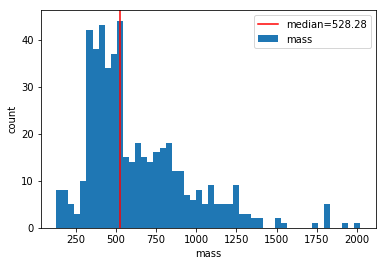

In [144]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=50)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')
plt.axvline(x=np.median(f['mass']), color='red', label='median={:.2f}'.format(np.median(f['mass'])))
plt.legend()

In [145]:
plt.figure()
tp.annotate(f, tp1[1])

NameError: name 'tp1' is not defined

<Figure size 432x288 with 0 Axes>

In [151]:
f = tp.batch(frames_z2, 15, minmass=1000, percentile=0.95)

Frame 3: 144 features


In [152]:
t = tp.link_df(f, 10, memory=0)
t['frame'] = t['frame']+1

Frame 3: 144 trajectories present.


Let's only look at the particles that are in all four time points.

In [153]:
t1 = tp.filter_stubs(t, 3)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 360
After: 62


In [154]:
pd.concat(g for _, g in t.groupby("particle") if len(g) == 4)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
99,258.455253,14.130941,13191.726504,2.808717,0.441702,597.481296,18751.0,0.000090,1,3
235,255.661793,14.485185,4298.812661,2.288490,0.085394,291.659948,5863.0,0.000396,2,3
399,255.210120,15.584127,3682.437343,2.703241,0.286518,352.103875,4246.0,0.000112,3,3
547,260.451605,17.728835,8282.529473,1.910158,0.331109,661.012304,10566.0,0.000020,4,3
94,243.258987,345.084500,7628.231829,2.825975,0.456713,380.425131,10856.0,0.000155,1,8
229,238.340795,347.079768,1927.349647,2.250057,0.251527,172.282225,2490.0,0.000933,2,8
390,237.000000,350.000000,1045.483769,1.275719,0.213241,183.755864,1186.0,0.000400,3,8
538,240.629964,346.493349,10642.698625,2.215900,0.103256,860.622655,14783.0,0.000015,4,8
76,196.766360,159.855376,1578.825476,3.988932,0.831841,152.694455,2459.0,0.000686,1,23
212,191.536934,165.897060,5939.796963,3.059528,0.407534,369.885110,9319.0,0.000249,2,23


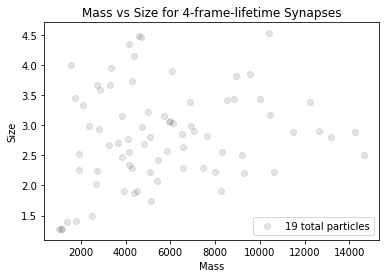

In [155]:
plt.figure()
plt.title('Mass vs Size for 4-frame-lifetime Synapses')
plt.xlabel('Mass')
plt.ylabel('Size')
df = pd.concat(g for _, g in t.groupby("particle") if len(g) == 4)
count = len(df.particle.unique())
plt.scatter(df['mass'], df['size'], c='k', alpha=0.1, label="{} total particles".format(count))
plt.legend()

In [156]:
t.loc[t['particle'] == 3]

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
99,258.455253,14.130941,13191.726504,2.808717,0.441702,597.481296,18751.0,0.000090,1,3
235,255.661793,14.485185,4298.812661,2.288490,0.085394,291.659948,5863.0,0.000396,2,3
399,255.210120,15.584127,3682.437343,2.703241,0.286518,352.103875,4246.0,0.000112,3,3
547,260.451605,17.728835,8282.529473,1.910158,0.331109,661.012304,10566.0,0.000020,4,3


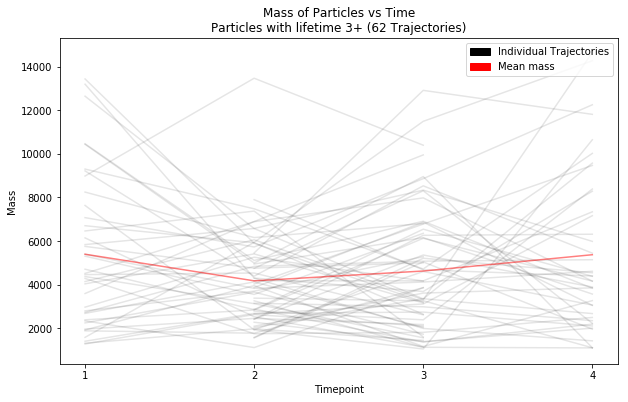

In [215]:
plt.figure(figsize=(10, 6))
plt.xlabel('Timepoint')
plt.xticks(np.arange(4))
plt.ylabel('Mass')
df = pd.concat(g for _, g in t.groupby("particle") if len(g) >= 3)
for i in df.particle.unique():
    df1 = t.loc[t['particle'] == i]
    plt.plot(df1['frame'], df1['mass'], 'k-', alpha=0.1)
    plt.xticks(np.arange(1, 5, step=1))

means = [df[df['frame']==i]['mass'].mean() for i in range(1,5)]
plt.plot(df['frame'].unique(), means, 'r-', alpha=0.5)

trajectories = mpl.patches.Patch(color='k', label='Individual Trajectories')
mean = mpl.patches.Patch(color='r', label='Mean mass')
plt.legend(handles=[trajectories, mean], loc=1)
plt.title("Mass of Particles vs Time\nParticles with lifetime 3+ ({} Trajectories)".format(len(df.particle.unique())))


plt.savefig('../figures/mass_vs_time_min_lifetime_3.PNG', dpi=300)

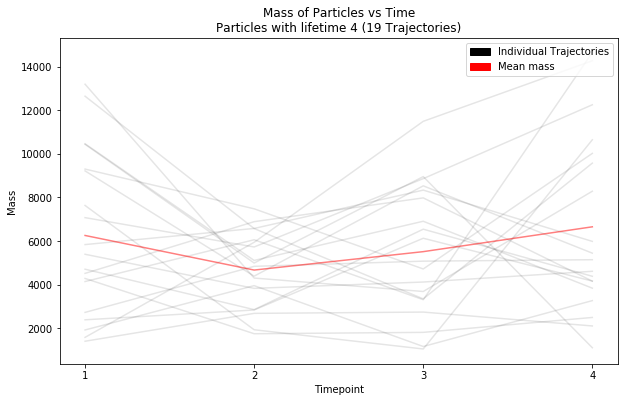

In [216]:
plt.figure(figsize=(10, 6))
plt.xlabel('Timepoint')
plt.xticks(np.arange(4))
plt.ylabel('Mass')
df = pd.concat(g for _, g in t.groupby("particle") if len(g) == 4)
for i in df.particle.unique():
    df1 = t.loc[t['particle'] == i]
    plt.plot(df1['frame'], df1['mass'], 'k-', alpha=0.1)
    plt.xticks(np.arange(1, 5, step=1))

means = [df[df['frame']==i]['mass'].mean() for i in range(1,5)]
plt.plot(df['frame'].unique(), means, 'r-', alpha=0.5)

trajectories = mpl.patches.Patch(color='k', label='Individual Trajectories')
mean = mpl.patches.Patch(color='r', label='Mean mass')
plt.legend(handles=[trajectories, mean], loc=1)
plt.title("Mass of Particles vs Time\nParticles with lifetime 4 ({} Trajectories)".format(len(df.particle.unique())))

plt.savefig('../figures/mass_vs_time_min_lifetime_4.PNG', dpi=300)

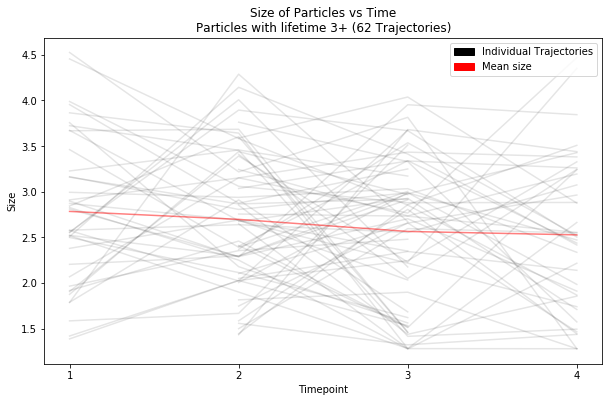

In [217]:
plt.figure(figsize=(10, 6))
plt.xlabel('Timepoint')
plt.xticks(np.arange(4))
plt.ylabel('Size')
df = pd.concat(g for _, g in t.groupby("particle") if len(g) >= 3)
for i in df.particle.unique():
    df1 = t.loc[t['particle'] == i]
    plt.plot(df1['frame'], df1['size'], 'k-', alpha=0.1)
    plt.xticks(np.arange(1, 5, step=1))
    
means = [df[df['frame']==i]['size'].mean() for i in range(1,5)]
plt.plot(df['frame'].unique(), means, 'r-', alpha=0.5)

trajectories = mpl.patches.Patch(color='k', label='Individual Trajectories')
mean = mpl.patches.Patch(color='r', label='Mean size')
plt.legend(handles=[trajectories, mean], loc=1)
plt.title("Size of Particles vs Time\nParticles with lifetime 3+ ({} Trajectories)".format(len(df.particle.unique())))
    
plt.savefig('../figures/size_vs_time_min_lifetime_3.PNG', dpi=300)

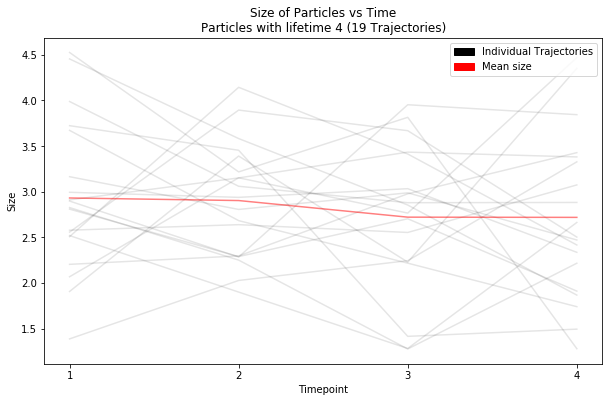

In [218]:
plt.figure(figsize=(10, 6))
plt.xlabel('Timepoint')
plt.xticks(np.arange(4))
plt.ylabel('Size')
df = pd.concat(g for _, g in t.groupby("particle") if len(g) == 4)
for i in df.particle.unique():
    df1 = t.loc[t['particle'] == i]
    plt.plot(df1['frame'], df1['size'], 'k-', alpha=0.1)
    plt.xticks(np.arange(1, 5, step=1))
    
    
means = [df[df['frame']==i]['size'].mean() for i in range(1,5)]
plt.plot(df['frame'].unique(), means, 'r-', alpha=0.5)

trajectories = mpl.patches.Patch(color='k', label='Individual Trajectories')
mean = mpl.patches.Patch(color='r', label='Mean size')
plt.legend(handles=[trajectories, mean], loc=1)
plt.title("Size of Particles vs Time\nParticles with lifetime 4 ({} Trajectories)".format(len(df.particle.unique())))

    
plt.savefig('../figures/size_vs_time_min_lifetime_4.PNG', dpi=300)

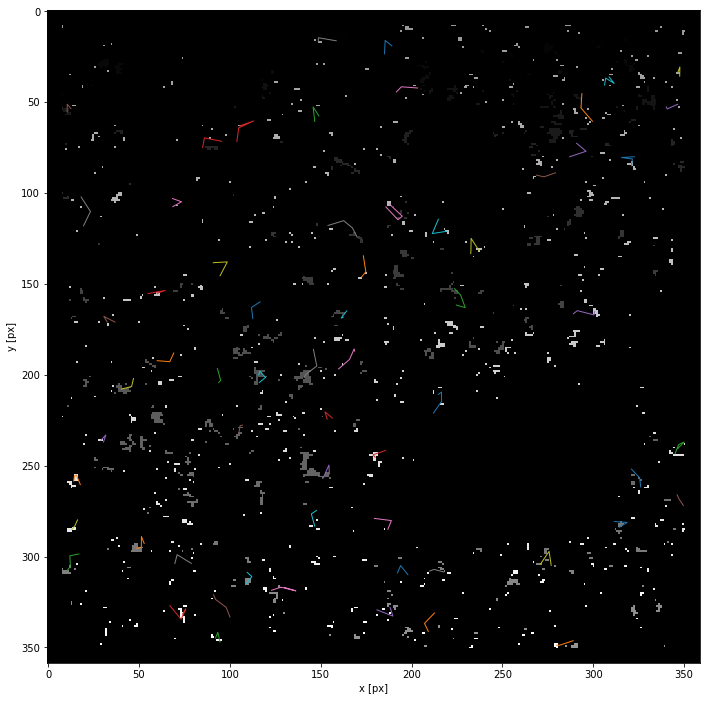

In [219]:
plt.figure(figsize=(12,12))
tp.plot_traj(t1, superimpose=frames_z2[0]);

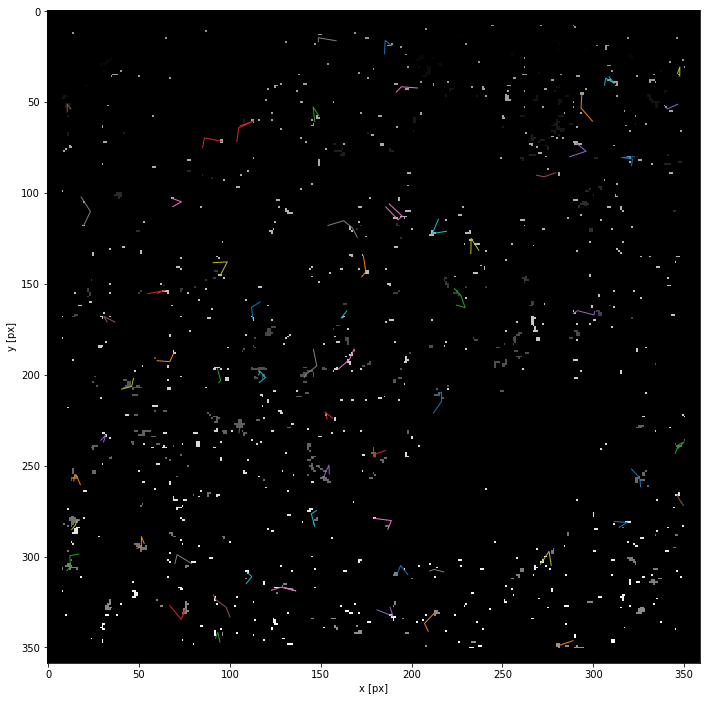

In [160]:
plt.figure(figsize=(12,12))
tp.plot_traj(t1, superimpose=frames_z2[1]);

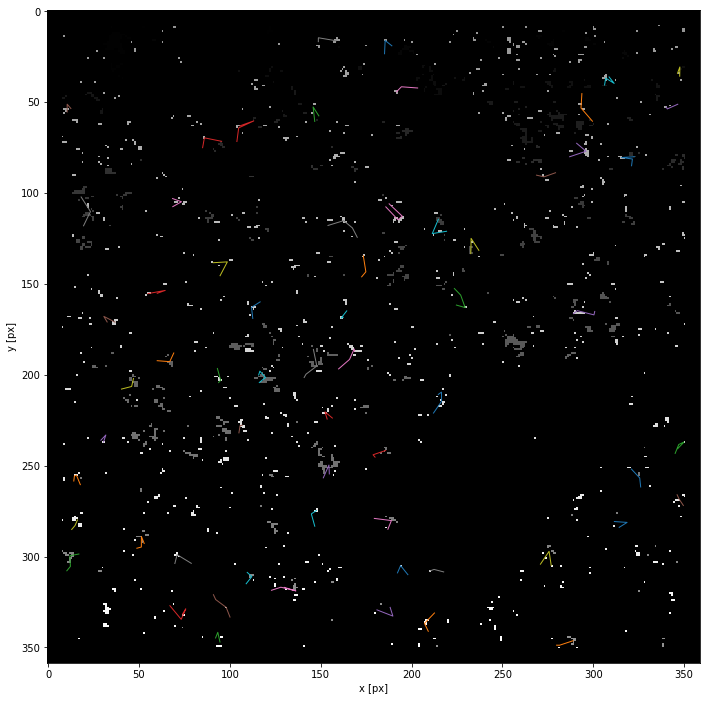

In [161]:
plt.figure(figsize=(12,12))
tp.plot_traj(t1, superimpose=frames_z2[2]);

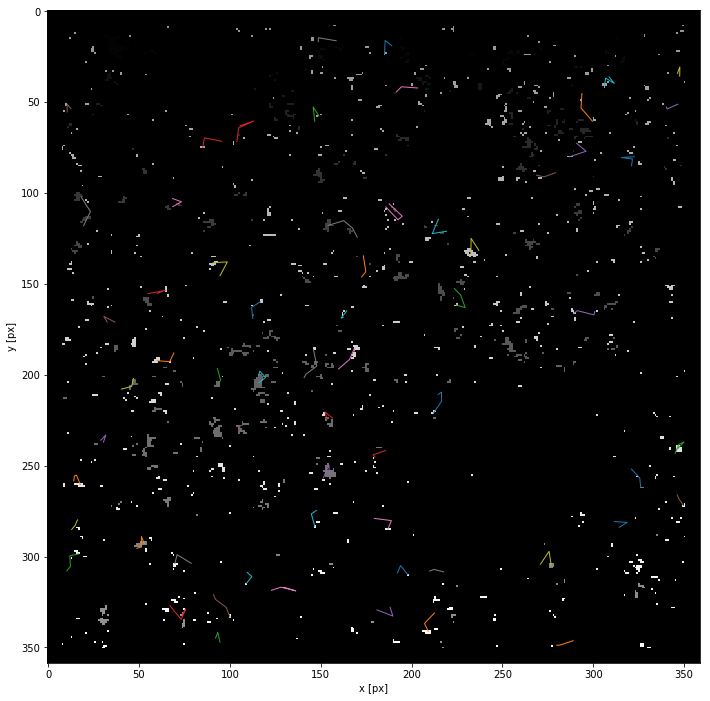

In [263]:
plt.figure(figsize=(12,12))
tp.plot_traj(t1, superimpose=frames_z2[3]);